## Import Packages

In [27]:
import pandas as pd
import numpy as np
import os

## Import Data

In [29]:
# Read in the data
path = 'Data/'
files = [os.path.join(path, file) for file in os.listdir(path) if file.endswith('.csv')]

df = pd.concat((pd.read_csv(file) for file in files), ignore_index=True)
df.head()

,noOfUnits,tenure,marketSegment,typeOfSale,district,nettPrice,x,propertyType,price,project,y,floorRange,area,street,contractDate,typeOfArea
0,1,Freehold,RCR,3,5,NaN,20914.198897,Strata Terrace,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,-,186.0,NEO PEE TECK LANE,321,Strata
1,1,Freehold,RCR,3,5,NaN,20914.198897,Terrace,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,-,257.0,NEO PEE TECK LANE,522,Land
2,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5200000,LANDED HOUSING DEVELOPMENT,NaN,-,308.0,ZEHNDER ROAD,921,Land
3,1,Freehold,RCR,3,5,NaN,NaN,Semi-detached,5188888,LANDED HOUSING DEVELOPMENT,NaN,-,228.4,ZEHNDER ROAD,724,Land
4,1,99 yrs lease commencing from 2024,CCR,1,7,NaN,NaN,Apartment,2065000,AUREA,NaN,21-25,66.0,BEACH ROAD,925,Strata


## Process Data

In [30]:
# Remove duplicates
df_raw = df.copy()
df = df.drop_duplicates()

In [31]:
# Map contractDate to Month and Year
df['contractYear'] = df['contractDate'].apply(lambda x: x % 100 + 2000)
df['contractMonth'] = df['contractDate'].apply(lambda x: x // 100)

# Separate tenure into tenure duration and start year
df['tenure'] = df['tenure'].str.lower()     # Convert to lowercase for consistency
df['tenureDuration'] = df['tenure'].apply(lambda x: np.inf if 'freehold' in str(x) else int(x.split(' ')[0]) if isinstance(x, str) and len(x.split(' ')) > 1 else np.nan)      # If 'freehold' then 0, if NaN then NaN
df['tenureStartYear'] = df['tenure'].apply(lambda x: int(x.split(' ')[-1]) if isinstance(x, str) and len(x.split(' ')) > 3 else np.nan)     # If 'freehold' or '99 years lease' then nan
df['tenureRemaining'] = df.apply(lambda x: np.inf if 'freehold' in str(x['tenure']) else (x['tenureDuration'] - (x['contractYear'] - x['tenureStartYear'])) if not pd.isna(x['tenureStartYear']) else np.nan, axis=1)

# Map propertyType to numerical values
print(df['propertyType'].unique())
Mapping_PropertyType = {
    'Strata Terrace': 1,
    'Terrace': 2,
    'Semi-detached': 3,
    'Apartment': 4,
    'Condominium': 5,
    'Deteched': 6,
    'Strata Semi-detached': 7,
    'Strata Deteched': 8,
    'Executive Condominium': 9}
df['propertyType'] = df['propertyType'].map(Mapping_PropertyType)

# Map floorRange to numerical values
df['floorRange'] = df['floorRange'].apply(lambda x: -int(x.split('-')[-1].replace('B','')) if isinstance(x,str) and 'B' in x and x.strip() not in ['-',''] else int(x.split('-')[-1]) if isinstance(x,str) and len(x.split('-')[-1])==2 and x.strip() not in ['-',''] else np.nan)
 
# Map typeOfArea to numerical values
df['typeOfArea'] = df['typeOfArea'].apply(lambda x: 1 if isinstance(x,str) and x == 'Strata' else 2 if isinstance(x,str) and x == 'Land' else x)

# Drop nettPrice
df = df.drop(columns=['nettPrice', 'tenure', 'contractDate'])

df_copy = df.copy()
df.head()

['Strata Terrace' 'Terrace' 'Semi-detached' 'Apartment' 'Condominium'
 'Detached' 'Strata Semi-detached' 'Strata Detached'
 'Executive Condominium']


,noOfUnits,marketSegment,typeOfSale,district,x,propertyType,price,project,y,floorRange,area,street,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
0,1,RCR,3,5,20914.198897,1.0,1880000,LANDED HOUSING DEVELOPMENT,30589.107079,NaN,186.0,NEO PEE TECK LANE,1,2021,3,inf,NaN,inf
1,1,RCR,3,5,20914.198897,2.0,4600000,LANDED HOUSING DEVELOPMENT,30589.107079,NaN,257.0,NEO PEE TECK LANE,2,2022,5,inf,NaN,inf
2,1,RCR,3,5,NaN,3.0,5200000,LANDED HOUSING DEVELOPMENT,NaN,NaN,308.0,ZEHNDER ROAD,2,2021,9,inf,NaN,inf
3,1,RCR,3,5,NaN,3.0,5188888,LANDED HOUSING DEVELOPMENT,NaN,NaN,228.4,ZEHNDER ROAD,2,2024,7,inf,NaN,inf
4,1,CCR,1,7,NaN,4.0,2065000,AUREA,NaN,25.0,66.0,BEACH ROAD,1,2025,9,99.0,2024.0,98.0


## Price Prediction - Linear Regression

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

In [33]:
# Drop rows with missing target variable
print(df_copy.shape)
df = df_copy.dropna()
print(df.shape)

# Predicting 'price' using other columns
X = df.drop('price', axis=1)
y = df['price']

# Handle missing values
#X = X.fillna(np.nan)

# Encode categorical variables
X = pd.get_dummies(X)
print(X.shape, y.shape)

(134403, 18)
(78286, 18)
(78286, 1128) (78286,)


In [34]:
# Split the data into training and testing sets
# seed 40 has the best results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

In [35]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
# Make predictions
y_pred = model.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

pd.set_option('display.float_format', '{:.0f}'.format)
print(comparison.head(20))  # Show first 10 rows

     Actual  Predicted
0   2770000    2806572
1   1818000    1983745
2    990000     870515
3   1245000    1141896
4   1790000    1430334
5   1568888    1597063
6   1488000    1395963
7   1125000    1001973
8   1400000    1445831
9   1938000    1864367
10  1368000    1362836
11  2530000    2498644
12  2420000    2299433
13  1080000    1004207
14  1058000    1194851
15  2508000    2647199
16   535000     356976
17  1253240    1068776
18  1390000    1405151
19  1608000    1582695


In [44]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}, R²: {r2:.5f}', f'RMSE: {rmse:.2f}', f'MAE: {mae:.2f}')

MSE: 266076433601.27, R²: 0.99561 RMSE: 515825.97 MAE: 153550.50


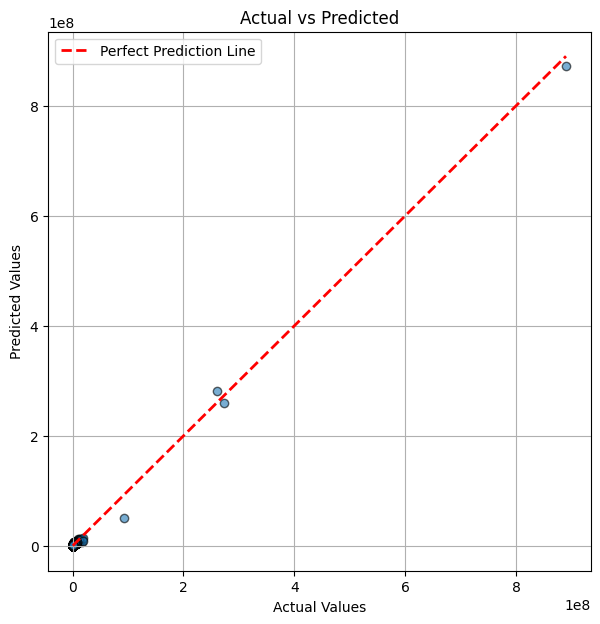

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance[:20].reset_index(drop=True))

                             Feature  Coefficient
0                  street_HORNE ROAD     -9482922
1             street_GUILLEMARD ROAD     -9243780
2               street_BOUNDARY ROAD     -7290364
3          project_INSTITUTION VILLE      7057185
4   project_SEVEN PALMS SENTOSA COVE      5109117
5     project_SOUTH BEACH RESIDENCES      4774787
6        project_WATERFORD RESIDENCE     -4331487
7             project_LANGSTON VILLE     -4310479
8        project_ATTITUDE AT KIM YAM     -4143353
9               street_STAMFORD ROAD      3517779
10   project_EDEN RESIDENCES CAPITOL      3517779
11                project_ASPEN LINQ     -3475594
12                   project_THE 101     -3440668
13                project_HILL HOUSE     -3111816
14    project_THE ORCHARD RESIDENCES      2985331
15                      project_75BR     -2955636
16             street_TONG WATT ROAD     -2156937
17       street_UPPER SERANGOON ROAD      2153690
18                 project_TURQUOISE     -2105810


Regression has high accuracy due to street name and project. This reveals too much information as properties in the same project and on certain streets will have a similar distribution of prices.

In [53]:
df_copy[(df_copy['project'] == "TURQUOISE") & (df_copy['contractYear'] == 2022)]

,noOfUnits,marketSegment,typeOfSale,district,x,propertyType,price,project,y,floorRange,area,street,typeOfArea,contractYear,contractMonth,tenureDuration,tenureStartYear,tenureRemaining
55,1,CCR,3,4,28382,5,3108150,TURQUOISE,25008,5,199,COVE DRIVE,1,2022,1,99,2007,84
58,1,CCR,3,4,28382,5,4169770,TURQUOISE,25008,5,226,COVE DRIVE,1,2022,1,99,2007,84
64,1,CCR,3,4,28382,5,4049560,TURQUOISE,25008,5,223,COVE DRIVE,1,2022,4,99,2007,84
65,1,CCR,3,4,28382,5,4068160,TURQUOISE,25008,5,224,COVE DRIVE,1,2022,5,99,2007,84
66,1,CCR,3,4,28382,5,3254850,TURQUOISE,25008,5,224,COVE DRIVE,1,2022,3,99,2007,84
67,1,CCR,3,4,28382,5,3254850,TURQUOISE,25008,5,224,COVE DRIVE,1,2022,4,99,2007,84
68,1,CCR,3,4,28382,5,3071880,TURQUOISE,25008,5,199,COVE DRIVE,1,2022,1,99,2007,84
69,1,CCR,3,4,28382,5,4448210,TURQUOISE,25008,10,290,COVE DRIVE,1,2022,2,99,2007,84
70,1,CCR,3,4,28382,5,4127920,TURQUOISE,25008,5,225,COVE DRIVE,1,2022,3,99,2007,84
71,1,CCR,3,4,28382,5,3399680,TURQUOISE,25008,5,239,COVE DRIVE,1,2022,10,99,2007,84


### Price Prediction Without Project Column

In [240]:
# Drop rows with missing target variable
df = df_copy.dropna()

# Predicting 'price' using other columns
X = df.drop(columns = ['price', 'project'],  axis=1)
y = df['price']

# Handle missing values
#X = X.fillna(np.nan)

# Encode categorical variables
X = pd.get_dummies(X)
print(X.shape, y.shape)

# Split the data into training and testing sets
# seed 40 has the best results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

pd.set_option('display.float_format', '{:.0f}'.format)
print(comparison.head(20))  # Show first 10 rows

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}, R²: {r2:.5f}')

(78286, 451) (78286,)
     Actual  Predicted
0   2770000    2312853
1   1818000    1962868
2    990000     951970
3   1245000    1237215
4   1790000    1471736
5   1568888    1606132
6   1488000    1461007
7   1125000    1099180
8   1400000    1395383
9   1938000    1853333
10  1368000    1373897
11  2530000    2513056
12  2420000    2188657
13  1080000    1106783
14  1058000    1209668
15  2508000    2497762
16   535000    -275951
17  1253240    1064361
18  1390000    1429061
19  1608000    1593786
MSE: 531773276410.94, R²: 0.99124


In [241]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance[:20].reset_index(drop=True))

                         Feature  Coefficient
0              street_HORNE ROAD   -358038181
1         street_GUILLEMARD ROAD   -357426371
2           street_BOUNDARY ROAD   -355826691
3           street_STAMFORD ROAD      8268870
4               street_BOAT QUAY      6385750
5       street_JALAN TARI DULANG      5137827
6       street_ORCHARD BOULEVARD      4237267
7         street_BROOKVALE DRIVE      4175220
8          street_WALLICH STREET      4117750
9             street_SIGLAP LINK      4014245
10         street_LENTOR CENTRAL      3940612
11           street_LORONG CHUAN      3931146
12          street_GATEWAY DRIVE      3848474
13          street_BEDOK CENTRAL      3802636
14        street_FERNVALE STREET      3767764
15           street_CHU LIN ROAD      3736974
16  street_UPPER PAYA LEBAR ROAD      3727912
17          street_FERNVALE ROAD      3720112
18          street_FERNVALE LANE      3709943
19           street_SELETAR ROAD      3690805


The linear regression model still makes good predictions despite dropping the projects column.

### Price Prediction Without Project and Street Column

In [242]:
# Drop rows with missing target variable
df = df_copy.dropna()

# Predicting 'price' using other columns
X = df.drop(columns = ['price', 'project', 'street'],  axis=1)
y = df['price']

# Handle missing values
#X = X.fillna(np.nan)

# Encode categorical variables
X = pd.get_dummies(X)
print(X.shape, y.shape)

# Split the data into training and testing sets
# seed 40 has the best results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})

pd.set_option('display.float_format', '{:.0f}'.format)
print(comparison.head(20))  # Show first 10 rows

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse:.2f}, R²: {r2:.5f}')

(78286, 17) (78286,)
     Actual  Predicted
0   2770000    2199145
1   1818000    1686329
2    990000     899087
3   1245000    1261268
4   1790000    2010647
5   1568888    1554759
6   1488000    1338460
7   1125000    1225064
8   1400000    1756988
9   1938000    2541027
10  1368000    1480868
11  2530000    2250098
12  2420000    1934943
13  1080000    1343479
14  1058000    1753813
15  2508000    2509649
16   535000     -25577
17  1253240    1662095
18  1390000    1147229
19  1608000    1602428
MSE: 695323701606.99, R²: 0.98854


In [243]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance[:].reset_index(drop=True))

              Feature  Coefficient
0          typeOfArea       933593
1   marketSegment_CCR       327619
2   marketSegment_OCR      -280854
3          typeOfSale      -259551
4        contractYear        98104
5           noOfUnits        96940
6   marketSegment_RCR       -46765
7        propertyType       -39026
8     tenureStartYear        33345
9     tenureRemaining       -32381
10     tenureDuration        32379
11      contractMonth        16496
12               area        15792
13         floorRange         9802
14           district         -356
15                  y          -18
16                  x            0


The regression model still makes really good predictions.  
Conclusion: Linear regression is a good model for making predictions of property prices.

## Price Prediction - Random Forest

In [244]:
from sklearn.ensemble import RandomForestRegressor

# Drop rows with missing target variable
df = df_copy.dropna()

# Predicting 'price' using other columns
X = df.drop(columns = ['price', 'project', 'street'],  axis=1)
y = df['price']

# Handle missing values
#X = X.fillna(np.nan)

# Encode categorical variables
X = pd.get_dummies(X)
print(X.shape, y.shape)

# Split the data into training and testing sets
# seed 40 has the best results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create and train the model
rf = RandomForestRegressor(
    n_estimators=400,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,
    n_jobs=-1              # use all CPU cores for speed
)

rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
print(comparison.head(20))  # Show first 10 rows

(78286, 17) (78286,)
     Actual  Predicted
0   2770000    2863515
1   1818000    1767922
2    990000     998182
3   1245000    1278367
4   1790000    1824262
5   1568888    1533773
6   1488000    1526562
7   1125000    1113030
8   1400000    1373844
9   1938000    1707051
10  1368000    1366324
11  2530000    2721430
12  2420000    2414785
13  1080000    1069460
14  1058000    1052841
15  2508000    2436516
16   535000     549977
17  1253240    1209639
18  1390000    1081425
19  1608000    1584050


In [245]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.3f}")


MSE: 56,047,227,890,063.18
RMSE: 7,486,469.65
R²: 0.076


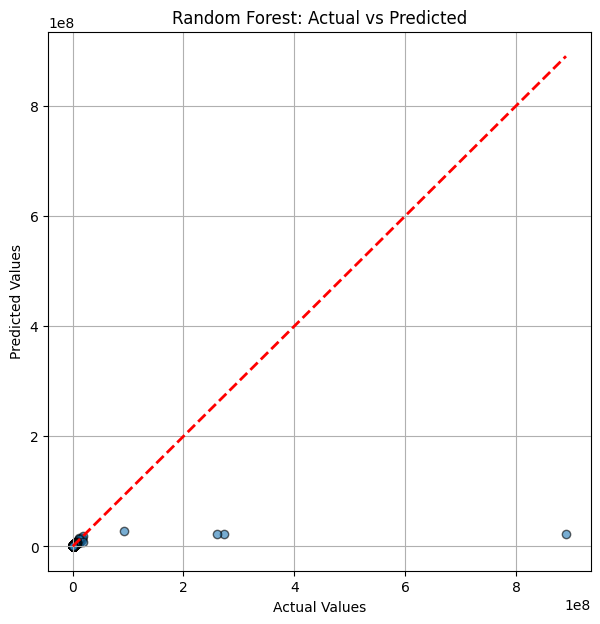

In [246]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()

In [247]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance[:].reset_index(drop=True))


              Feature  Coefficient
0          typeOfArea       933593
1   marketSegment_CCR       327619
2   marketSegment_OCR      -280854
3          typeOfSale      -259551
4        contractYear        98104
5           noOfUnits        96940
6   marketSegment_RCR       -46765
7        propertyType       -39026
8     tenureStartYear        33345
9     tenureRemaining       -32381
10     tenureDuration        32379
11      contractMonth        16496
12               area        15792
13         floorRange         9802
14           district         -356
15                  y          -18
16                  x            0


Pretty good predictions but R-square is affected by properties with high prices.

### Price Prediction For Properties Price Below 2,000,000 

In [248]:
from sklearn.ensemble import RandomForestRegressor

# Drop rows with missing target variable
df = df_copy.dropna()
df=df[df['price']<2_000_000]

# Predicting 'price' using other columns
X = df.drop(columns = ['price', 'project', 'street'],  axis=1)
y = df['price']

# Handle missing values
#X = X.fillna(np.nan)

# Encode categorical variables
X = pd.get_dummies(X)
print(X.shape, y.shape)

# Split the data into training and testing sets
# seed 40 has the best results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create and train the model
rf = RandomForestRegressor(
    n_estimators=400,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,
    n_jobs=-1              # use all CPU cores for speed
)

rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
print(comparison.head(20))  # Show first 10 rows

(63360, 17) (63360,)
     Actual  Predicted
0   1200000    1124262
1   1280000    1225332
2   1210000    1213145
3   1168000    1222214
4   1528000    1328222
5   1320000    1283664
6   1620000    1636705
7   1655000    1575095
8   1818000    1851053
9   1385000    1351531
10  1750000    1755273
11   840000     926802
12  1036000    1052403
13  1120000    1127373
14  1262000    1270762
15   958000     950955
16  1468888    1471996
17  1020000    1052198
18  1395000    1404130
19  1450000    1451969


In [249]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.3f}")


MSE: 4,421,605,978.24
RMSE: 66,495.16
R²: 0.962


In [250]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance[:].reset_index(drop=True))

              Feature  Coefficient
0          typeOfArea       933593
1   marketSegment_CCR       327619
2   marketSegment_OCR      -280854
3          typeOfSale      -259551
4        contractYear        98104
5           noOfUnits        96940
6   marketSegment_RCR       -46765
7        propertyType       -39026
8     tenureStartYear        33345
9     tenureRemaining       -32381
10     tenureDuration        32379
11      contractMonth        16496
12               area        15792
13         floorRange         9802
14           district         -356
15                  y          -18
16                  x            0


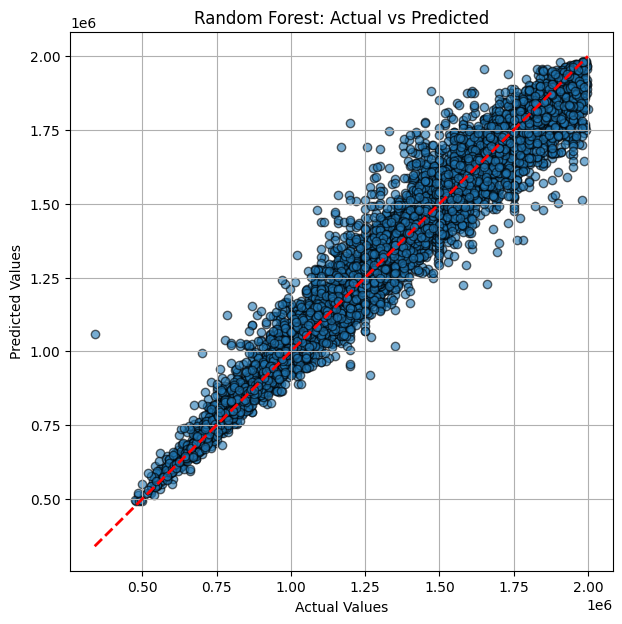

In [251]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()

### Price Prediction For Properties Price Below 10,000,000 

In [252]:
from sklearn.ensemble import RandomForestRegressor

# Drop rows with missing target variable
df = df_copy.dropna()
df=df[df['price']<10_000_000]

# Predicting 'price' using other columns
X = df.drop(columns = ['price', 'project', 'street'],  axis=1)
y = df['price']

# Handle missing values
#X = X.fillna(np.nan)

# Encode categorical variables
X = pd.get_dummies(X)
print(X.shape, y.shape)

# Split the data into training and testing sets
# seed 40 has the best results
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create and train the model
rf = RandomForestRegressor(
    n_estimators=400,      # number of trees
    max_depth=None,        # let trees expand fully
    random_state=42,
    n_jobs=-1              # use all CPU cores for speed
)

rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Combine actual and predicted values
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred
})
print(comparison.head(20))  # Show first 10 rows

(78215, 17) (78215,)
     Actual  Predicted
0   1150000    1130042
1    615000     607455
2   1500000    1536057
3   1300000    1276647
4   2388000    2395575
5   1880000    1804741
6   1120000    1085506
7   2476000    2491235
8   1500000    1892978
9    790000     793335
10  2100000    2204938
11   950000     995667
12  1830000    1842224
13  5000000    4819833
14  2345155    2274291
15  1348000    1441522
16  1538000    1468714
17  1628000    1610489
18  1580000    1617182
19   750000     788747


In [253]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.3f}")


MSE: 17,464,091,184.62
RMSE: 132,151.77
R²: 0.971


In [254]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(importance[:].reset_index(drop=True))


              Feature  Coefficient
0          typeOfArea       933593
1   marketSegment_CCR       327619
2   marketSegment_OCR      -280854
3          typeOfSale      -259551
4        contractYear        98104
5           noOfUnits        96940
6   marketSegment_RCR       -46765
7        propertyType       -39026
8     tenureStartYear        33345
9     tenureRemaining       -32381
10     tenureDuration        32379
11      contractMonth        16496
12               area        15792
13         floorRange         9802
14           district         -356
15                  y          -18
16                  x            0


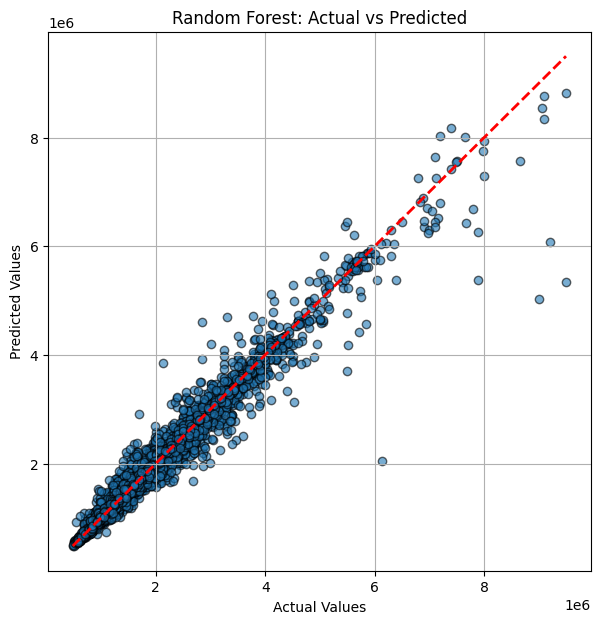

In [255]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.show()

Prediction gets poorer as actual price of property sold increases.